In [ ]:
// https://gist.github.com/belovrv/a09b8c291196766bf482795290b97654

In [3]:
%use adventOfCode

In [4]:
val today = AocClient.fromEnv().interactiveDay(2025, 4)
today.viewPartOne()

--- Day 4: Printing Department --- 
 You ride the escalator down to the printing department. They're clearly getting ready for Christmas; they have lots of large rolls of paper everywhere, and there's even a massive printer in the corner (to handle the really big print jobs). 
 Decorating here will be easy: they can make their own decorations. What you really need is a way to get further into the North Pole base while the elevators are offline. 
 "Actually, maybe we can help with that," one of the Elves replies when you ask for help. "We're pretty sure there's a cafeteria on the other side of the back wall. If we could break through the wall, you'd be able to keep moving. It's too bad all of our forklifts are so busy moving those big rolls of paper around." 
 If you can optimize the work the forklifts are doing, maybe they would have time to spare to break through the wall. 
 The rolls of paper ( @ ) are arranged on a large grid; the Elves even have a helpful diagram (your puzzle input) indicating where everything is located. 
 For example: 
 ..@@.@@@@.
@@@.@.@.@@
@@@@@.@.@@
@.@@@@..@.
@@.@@@@.@@
.@@@@@@@.@
.@.@.@.@@@
@.@@@.@@@@
.@@@@@@@@.
@.@.@@@.@.
 
 The forklifts can only access a roll of paper if there are fewer than four rolls of paper in the eight adjacent positions. If you can figure out which rolls of paper the forklifts can access, they'll spend less time looking and more time breaking down the wall to the cafeteria. 
 In this example, there are 13 rolls of paper that can be accessed by a forklift (marked with x ): 
 ..xx.xx@x.
x@@.@.@.@@
@@@@@.x.@@
@.@@@@..@.
x@.@@@@.@x
.@@@@@@@.@
.@.@.@.@@@
x.@@@.@@@@
.@@@@@@@@.
x.x.@@@.x.
 
 Consider your complete diagram of the paper roll locations. How many rolls of paper can be accessed by a forklift?

In [5]:
val input = """
..@@.@@@@.
@@@.@.@.@@
@@@@@.@.@@
@.@@@@..@.
@@.@@@@.@@
.@@@@@@@.@
.@.@.@.@@@
@.@@@.@@@@
.@@@@@@@@.
@.@.@@@.@.
""".trim()

In [6]:
val arr = input.lines().map { it.toCharArray() }

In [7]:
/**
 * Converte una List<CharArray> in una List<IntArray> calcolando per ogni cella
 * la somma degli 8 vicini adiacenti.
 * Un vicino '@' contribuisce con 1, qualsiasi altro carattere con 0.
 */
fun List<CharArray>.toIntGrid(): List<IntArray> {
	val height = this.size
	val width = this[0].size

	// Crea la nuova griglia di interi (risultato)
	val resultGrid = List(height) { IntArray(width) }

	// I vettori di spostamento per gli 8 vicini:
	// [-1, -1] [-1, 0] [-1, 1]
	// [ 0, -1] [Cell] [ 0, 1]
	// [ 1, -1] [ 1, 0] [ 1, 1]
	val dx = intArrayOf(-1, -1, -1, 0, 0, 1, 1, 1)
	val dy = intArrayOf(-1, 0, 1, -1, 1, -1, 0, 1)

	for (y in 0 until height) {
		for (x in 0 until width) {
			var count = 0
			for (i in 0 until 8) {
				val ny = y + dy[i]
				val nx = x + dx[i]

				// Controlla che le coordinate del vicino siano all'interno dei limiti della griglia
				if (ny >= 0 && ny < height && nx >= 0 && nx < width) {
					// Se il vicino è '@', aggiungi 1. Altrimenti aggiungi 0.
					if (this[ny][nx] == '@') {
						count += 1
					}
				}
			}
			resultGrid[y][x] = count
		}
	}
	return resultGrid
}

In [8]:
val arr1 = arr.toIntGrid()

In [9]:
import java.awt.image.BufferedImage
import java.awt.Color

/**
 * Converte una List<IntArray> in una BufferedImage a toni di grigio.
 * Il valore di ogni cella (0-8) è mappato all'intervallo di colore da 0 a 255.
 *
 * @param pixelSize La dimensione (in pixel) di ogni blocco della griglia.
 * @return La BufferedImage risultante.
 */
fun List<IntArray>.toGrayscaleImage(pixelSize: Int): BufferedImage {
	if (this.isEmpty()) return BufferedImage(1, 1, BufferedImage.TYPE_BYTE_GRAY)

	val height = this.size
	val width = this[0].size

	val imageWidth = width * pixelSize
	val imageHeight = height * pixelSize

	// Crea l'immagine a toni di grigio (TYPE_BYTE_GRAY è ottimale)
	val image = BufferedImage(imageWidth, imageHeight, BufferedImage.TYPE_BYTE_GRAY)
	val graphics = image.createGraphics()

	// Calcola il fattore di scala:
	// Valori da 0 a 8 devono essere mappati a toni di grigio da 0 a 255.
	// Il grigio è (value * 255 / 8).
	val scaleFactor = 255.0 / 8.0

	for (y in 0 until height) {
		for (x in 0 until width) {
			val value = this[y][x]

			// Mappa il valore [0..8] al tono di grigio [0..255]
			val grayValue = (value * scaleFactor).toInt()

			// Crea il colore a toni di grigio (es. RGB(50, 50, 50) è grigio)
			val color = Color(grayValue, grayValue, grayValue)

			graphics.color = color

			// Disegna un rettangolo (il nostro "pixel" ingrandito)
			graphics.fillRect(x * pixelSize, y * pixelSize, pixelSize, pixelSize)
		}
	}

	graphics.dispose()
	return image
}

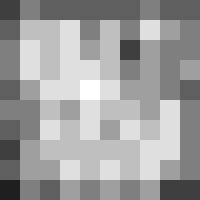

In [10]:
arr1.toGrayscaleImage(20)

In [11]:
import javax.swing.*
import java.awt.*
import java.awt.event.MouseEvent
import java.awt.event.MouseMotionAdapter

/**
 * Converte una List<IntArray> in un JPanel interattivo.
 * Il pannello visualizza la griglia a toni di grigio e mostra un tooltip
 * con il valore della cella quando il mouse passa sopra.
 *
 * @param pixelSize La dimensione (in pixel) di ogni blocco della griglia.
 * @return Un JPanel che visualizza la griglia con interazione al mouse.
 */
fun List<IntArray>.toInteractivePanel(pixelSize: Int): JPanel {
	if (this.isEmpty()) return JPanel()

	val gridData = this
	val height = gridData.size
	val width = gridData[0].size

	// Calcola la dimensione totale del pannello
	val panelWidth = width * pixelSize
	val panelHeight = height * pixelSize

	// Calcola il fattore di scala per i colori (da 0-8 a 0-255)
	val scaleFactor = 255.0 / 8.0

	// JPanel personalizzato
	val panel = object : JPanel() {
		init {
			preferredSize = Dimension(panelWidth, panelHeight)
			toolTipText = "" // Abilita il supporto ai Tooltip
		}

		// Sovrascrivi paintComponent per disegnare la griglia
		override fun paintComponent(g: Graphics) {
			super.paintComponent(g)
			val g2d = g as Graphics2D

			for (y in 0 until height) {
				for (x in 0 until width) {
					val value = gridData[y][x]

					// Mappa il valore [0..8] al tono di grigio [0..255]
					val grayValue = (value * scaleFactor).toInt()
					val color = Color(grayValue, grayValue, grayValue)

					g2d.color = color
					// Disegna il blocco
					g2d.fillRect(x * pixelSize, y * pixelSize, pixelSize, pixelSize)

					// Opzionale: disegna un bordo per distinguere le celle
					g2d.color = Color.DARK_GRAY
					g2d.drawRect(x * pixelSize, y * pixelSize, pixelSize, pixelSize)
				}
			}
		}

		// Sovrascrivi getToolTipText per mostrare il valore corretto al mouse hover
		override fun getToolTipText(event: MouseEvent): String? {
			// Calcola le coordinate della cella (colonna e riga)
			val gridX = event.x / pixelSize
			val gridY = event.y / pixelSize

			// Controlla che le coordinate siano all'interno dei limiti
			if (gridX >= 0 && gridX < width && gridY >= 0 && gridY < height) {
				val value = gridData[gridY][gridX]
				return "Cella ($gridY, $gridX): Vicini '@' = $value"
			}
			return null // Nessun tooltip se fuori griglia
		}
	}

	// Per assicurare che il tooltip sia mostrato correttamente anche senza un Listener,
	// è sufficiente sovrascrivere getToolTipText.
	// L'uso di ToolTipManager gestisce l'aggiornamento.
	ToolTipManager.sharedInstance().registerComponent(panel)

	return panel
}

org.jetbrains.kotlinx.jupyter.exceptions.ReplCompilerException: at Cell In[11], line 14, column 9: No type arguments expected for class List
at Cell In[11], line 66, column 28: Overload resolution ambiguity: 
public final operator fun compareTo(other: Byte): Int defined in kotlin.Int
public final operator fun compareTo(other: Double): Int defined in kotlin.Int
public final operator fun compareTo(other: Float): Int defined in kotlin.Int
public open fun compareTo(other: Int): Int defined in kotlin.Int
public final operator fun compareTo(other: Long): Int defined in kotlin.Int
public final operator fun compareTo(other: Short): Int defined in kotlin.Int
at Cell In[11], line 66, column 59: Overload resolution ambiguity: 
public final operator fun compareTo(other: Byte): Int defined in kotlin.Int
public final operator fun compareTo(other: Double): Int defined in kotlin.Int
public final operator fun compareTo(other: Float): Int defined in kotlin.Int
public open fun compareTo(other: Int): Int defined in kotlin.Int
public final operator fun compareTo(other: Long): Int defined in kotlin.Int
public final operator fun compareTo(other: Short): Int defined in kotlin.Int